# INFO284 Group Project

## About
Participants: Candidate number: 196, 251, 281, 301

## Table of Contents
### 1. [Imports](#imports)
### 2. [Statistics](#statistics)
### 3. [Preliminary preprocessing](#preprocessing)
### 4. [Exploring the dataset](#exploration)
### 5. [Running the algorithms](#alg)
1. Predict property values using the **[K Nearest Neighbor](#alg_knn)** algorithm.
2. Predict property values using the **[Random Forest Regression](#alg_rfr)** algorithm.
3. Predict property values using the **[Linear Regression](#alg_lr)** algorithm.
4. Predict property values using the **[Neural Networks](#alg_nn)** algorithm.
5. Predict property values using the **[Ridge Regression](#alg_rr)** algorithm.
6. Predict property values using the **[XGBOOST Regression](#alg_xgb)** algorithm.
### 6. [Evaluation](#eval)
### 7. [Sources](#sources)

## 1. Imports
<a id='imports'></a>

In [1]:
# Package installations
import sys
!{sys.executable} -m pip install numpy pandas sklearn xgboost yellowbrick yapf seaborn


In [2]:
# Imports for dataprocessing
import pandas as pd
import numpy as np
from pandas import read_csv
from sklearn.impute import KNNImputer

# Libraries used in modeling
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import neighbors
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from statistics import mean
from sklearn.model_selection import GridSearchCV
from numpy import std
from numpy import absolute
import xgboost
from xgboost.sklearn import XGBRegressor
import warnings
import time
from sklearn.neural_network import MLPRegressor

#Libraries used for visualization
import seaborn as sns
import matplotlib.pyplot as plt
from yellowbrick.regressor import residuals_plot

#### 1.1. Load the data set
This is the dataset we will be using for this exam. We import the csv file and convert it do a pandas DataFrame.

In [3]:
# Data
data = pd.read_csv("nyc-rolling-sales.csv")
df = pd.DataFrame(data)

In [4]:
print("Number of rows in dataset is :", len(df))

Number of rows in dataset is : 84548


In [5]:
# Dropping duplicates in our dataset
print('Sum duplicates in the dataset is:', sum(df.duplicated()))
df.drop_duplicates(keep=False, inplace=True)

Sum duplicates in the dataset is: 0


The Dataset we are given is a dataset of NYC property prices between 2016-2017. We have been given 84 548 rows which should be a sufficient amount of rows to try to make predictions for properties with missing Sale Price.

## 2. Statistics
<a id='statistics'></a>

In [6]:
df.describe()

,Unnamed: 0,BOROUGH,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,YEAR BUILT,TAX CLASS AT TIME OF SALE
count,84548.000000,84548.000000,84548.000000,84548.000000,84548.000000,84548.000000,84548.000000,84548.000000,84548.000000,84548.000000
mean,10344.359878,2.998758,4237.218976,376.224015,10731.991614,2.025264,0.193559,2.249184,1789.322976,1.657485
std,7151.779436,1.289790,3568.263407,658.136814,1290.879147,16.721037,8.713183,18.972584,537.344993,0.819341
min,4.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4231.000000,2.000000,1322.750000,22.000000,10305.000000,0.000000,0.000000,1.000000,1920.000000,1.000000
50%,8942.000000,3.000000,3311.000000,50.000000,11209.000000,1.000000,0.000000,1.000000,1940.000000,2.000000
75%,15987.250000,4.000000,6281.000000,1001.000000,11357.000000,2.000000,0.000000,2.000000,1965.000000,2.000000
max,26739.000000,5.000000,16322.000000,9106.000000,11694.000000,1844.000000,2261.000000,2261.000000,2017.000000,4.000000


Observing that ZIP CODE,YEAR BUILT og SALES PRICE has 0 as min value. This needs to be fixed in preprocessing

In [7]:
df.head() #Observing the structure of the dataset

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


We observe that we have 22 coloums in out dataset. In the next section we will explore the coloums further.

## 3. Preliminary preprocessing
<a id='preprocessing'></a>
We will do some preliminary data cleanup here, but some of the pre-processing will be algorithm-speciffic and done in each sub-task. This is mostly data cleaning and datatype manipulation to make sure all columns have sane values, outliers are trimmed and missing values compensated for.

In [8]:
# 1. Check datatypes

In [9]:
df.dtypes #Observing that we have to change the type of different columns

Unnamed: 0                         int64
BOROUGH                            int64
NEIGHBORHOOD                      object
BUILDING CLASS CATEGORY           object
TAX CLASS AT PRESENT              object
BLOCK                              int64
LOT                                int64
EASE-MENT                         object
BUILDING CLASS AT PRESENT         object
ADDRESS                           object
APARTMENT NUMBER                  object
ZIP CODE                           int64
RESIDENTIAL UNITS                  int64
COMMERCIAL UNITS                   int64
TOTAL UNITS                        int64
LAND SQUARE FEET                  object
GROSS SQUARE FEET                 object
YEAR BUILT                         int64
TAX CLASS AT TIME OF SALE          int64
BUILDING CLASS AT TIME OF SALE    object
SALE PRICE                        object
SALE DATE                         object
dtype: object

In [10]:
# 2. Convert to usable data-types
df['SALE PRICE'] = pd.to_numeric(df['SALE PRICE'], errors='coerce')
df['BOROUGH'] = pd.to_numeric(df['BOROUGH'], errors='coerce')
df['GROSS SQUARE FEET'] = pd.to_numeric(df['GROSS SQUARE FEET'], errors='coerce')
df['LAND SQUARE FEET'] = pd.to_numeric(df['LAND SQUARE FEET'], errors='coerce')
df['COMMERCIAL UNITS'] = pd.to_numeric(df['COMMERCIAL UNITS'], errors='coerce')
df['RESIDENTIAL UNITS'] = pd.to_numeric(df['RESIDENTIAL UNITS'], errors='coerce')
df['TOTAL UNITS'] = pd.to_numeric(df['TOTAL UNITS'], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84548 entries, 0 to 84547
Data columns (total 22 columns):
Unnamed: 0                        84548 non-null int64
BOROUGH                           84548 non-null int64
NEIGHBORHOOD                      84548 non-null object
BUILDING CLASS CATEGORY           84548 non-null object
TAX CLASS AT PRESENT              84548 non-null object
BLOCK                             84548 non-null int64
LOT                               84548 non-null int64
EASE-MENT                         84548 non-null object
BUILDING CLASS AT PRESENT         84548 non-null object
ADDRESS                           84548 non-null object
APARTMENT NUMBER                  84548 non-null object
ZIP CODE                          84548 non-null int64
RESIDENTIAL UNITS                 84548 non-null int64
COMMERCIAL UNITS                  84548 non-null int64
TOTAL UNITS                       84548 non-null int64
LAND SQUARE FEET                  58296 non-null float64
GR

#### 3.1 Missing Data

We have to check if our dataset contains missing data, and also check how severe the problem is.

In [11]:
print("NaN:",df.isna().values.any())
print("Missing values in df =", sum(df.isna().sum())) # Observing that we have missing data in the dataset. 
print('==========================================================')

NaN: True
Missing values in df = 68425


There are 68425 missing values in our dataset. The missing data could be missing by a mistake or the data was never obtained by the creators of the dataset. Nevertheless, we have to consider how to best make use of the rows containing missing variables

In [12]:
# Percentage of data missing in each column
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df

,column_name,percent_missing
Unnamed: 0,Unnamed: 0,0.000000
BOROUGH,BOROUGH,0.000000
NEIGHBORHOOD,NEIGHBORHOOD,0.000000
BUILDING CLASS CATEGORY,BUILDING CLASS CATEGORY,0.000000
TAX CLASS AT PRESENT,TAX CLASS AT PRESENT,0.000000
BLOCK,BLOCK,0.000000
LOT,LOT,0.000000
EASE-MENT,EASE-MENT,0.000000
BUILDING CLASS AT PRESENT,BUILDING CLASS AT PRESENT,0.000000
ADDRESS,ADDRESS,0.000000


We observe that we are missing 32.65 % of Gross Square feet and 31,04 of Land Square feet. We are also missing 17.2 % of Sales price and values in YEAR BUILT and ZIP CODE that has the value 0, but these values do not show up in the dataframe above. We have to remove 0 values from sales price column as this will clearly give us wrong predictions. 

In [13]:
df['TAX CLASS AT PRESENT'].value_counts()

1     38633
2     30919
4      6140
2A     2521
2C     1915
1A     1444
1B     1234
2B      814
        738
1C      186
3         4
Name: TAX CLASS AT PRESENT, dtype: int64

In [14]:
df['BUILDING CLASS AT PRESENT'].unique()

array(['C2', 'C7', 'C4', 'D5', 'D9', 'D7', 'D1', 'C6', 'D0', 'D4', 'RR',
       ' ', 'R2', 'R4', 'S3', 'S4', 'S5', 'R1', 'R8', 'R9', 'K4', 'M9',
       'M3', 'RK', 'RS', 'A9', 'A4', 'B3', 'B1', 'S2', 'C0', 'R6', 'C5',
       'C3', 'C1', 'D6', 'S9', 'O2', 'O1', 'O3', 'O5', 'O6', 'K1', 'K2',
       'L9', 'L8', 'L1', 'H1', 'H8', 'H3', 'R5', 'G6', 'P7', 'M1', 'N2',
       'RB', 'RG', 'RT', 'K9', 'V1', 'GW', 'G2', 'I7', 'M4', 'Z9', 'B9',
       'D3', 'G9', 'I9', 'U6', 'O4', 'L3', 'H2', 'E1', 'Z3', 'RW', 'C9',
       'J5', 'N9', 'S1', 'A5', 'J8', 'B2', 'C8', 'F5', 'Q1', 'G7', 'G5',
       'G4', 'P2', 'Q9', 'Y1', 'RA', 'RP', 'O8', 'HR', 'G1', 'E7', 'I5',
       'R3', 'I4', 'H9', 'RH', 'D8', 'HB', 'J4', 'W2', 'P9', 'A7', 'D2',
       'S0', 'O7', 'O9', 'W3', 'HS', 'H6', 'J9', 'R0', 'HH', 'W8', 'W6',
       'A1', 'K5', 'F1', 'V9', 'A2', 'V0', 'G0', 'F4', 'E9', 'I3', 'W4',
       'V3', 'I1', 'A6', 'Q8', 'A3', 'Z0', 'W1', 'U1', 'F2', 'F9', 'GU',
       'I6', 'G8', 'P5', 'Y3', 'W9', 'M2', 'G3', 'V6

In [15]:
# 3. Remove superfluous columns
df.drop(df.columns[[0]], inplace=True, axis=1)
df.drop(['TAX CLASS AT PRESENT', 'EASE-MENT', 'BUILDING CLASS AT PRESENT', 'APARTMENT NUMBER',
         'SALE DATE', 'ADDRESS'], axis = 1, inplace=True)

We are dropping EASE-MENT because this column is empty. We are also dropping TAX CLASS AT PRESENT and BUILDING CLASS AT PRESENT, and keeping TAX CLASS AT TIME OF SALE and BUILDING CLASS AT TIME OF SALE. We have decided to drop APARTMENT NUMBER and ADDRESS because we believe this information will cause the model to be overfitted. We're also dropping SALE DATE. While it could have been useful to correct prices for inflation or find trends over time, we only have numbers from 2016-2017 which makes it practically useless.

#### 3.2 Imputation of missing data

Our data set contains missing values. The missing values can be classified in three ways; Missing Completely at Random, Missing at Random or Not Missing at Random. If the probability of a value missing is the same for all data, the data is classified as missing completely at random. If the probability of a value missing is the same within groups defined by the observed data, the data is missing at random. If neither of the classifications holds, we say that the observations are Not Missing at random. [1]

There are 6970 missing observations of YEAR BUILT. We believe the missing data is not missing at random and that the values belong to the time period 1920-1930. We assume that the sale price will not vary too much within this time interval and we therefore substitute the missing values with the mode 1920. Mean would not be good values to impute because we have a large time interval and there is an indication that the missing data will be located in the beginning of 1900.

Land Square Feet and Gross Square feet can be assumed missing completely at random. The mode and median of LSF is 2000, 2325 and mode for GSF is 2400, 1680 (Dismissing values of 0). We choose to use the median value for imputation. We choose to to a regression imputation on Zip Code based on neighborhood. We find the most frequent zip code in each neighborhood and substitute the value.

Note: If our hypothesis stated above is true, the outcome of the imputation is that we have more data points and hopefully a better model. Nevertheless, if our hypothesis is wrong this will harm our models ability to predict correctly. We should be mindful of this when executing imputations.

In [16]:
#YEAR BUILT
print('YEAR BUILT median is:', df['YEAR BUILT'].median()) #not suitable because of outliers
print('YEAR BUILT FEET mean is:', df['YEAR BUILT'].mean())
print('YEAR BUILT mode is:', df['YEAR BUILT'].mode())
df['YEAR BUILT'].value_counts() #0 has the most data points, followed by 1920
df['YEAR BUILT'] = df['YEAR BUILT'].replace([0],1920)

YEAR BUILT median is: 1940.0
YEAR BUILT FEET mean is: 1789.322976297488
YEAR BUILT mode is: 0    0
dtype: int64


As we can see, year 0 is the most frequent datavalue. This is obviously wrong. We see that 1920 and 1930 have by far the largest numbers of values. We therefore substitute the 1920 with values of 0 in YEARBUILT.

In [17]:
# LAND SQUARE FEET and GROSS SQUARE FEET

df['LAND SQUARE FEET'] = df['LAND SQUARE FEET'].replace([' -  '],0)
# Fixing error

print('LAND SQUARE FEET  median is:', df['LAND SQUARE FEET'].median()) 
print('LAND SQUARE FEET mean is:', df['LAND SQUARE FEET'].mean())
print('LAND SQUARE FEET mode is:', df['LAND SQUARE FEET'].mode())
print('GROSS SQUARE FEET  median is:', df['GROSS SQUARE FEET'].median()) 
print('GROSS SQUARE FEET mean is:', df['GROSS SQUARE FEET'].mean())
print('GROSS SQUARE FEET mode is:', df['GROSS SQUARE FEET'].mode())
df['GROSS SQUARE FEET'].value_counts()

LAND SQUARE FEET  median is: 2325.0
LAND SQUARE FEET mean is: 3941.675775353369
LAND SQUARE FEET mode is: 0    0.0
dtype: float64
GROSS SQUARE FEET  median is: 1680.0
GROSS SQUARE FEET mean is: 4045.707478572432
GROSS SQUARE FEET mode is: 0    0.0
dtype: float64


0.0        11417
2400.0       386
1800.0       361
2000.0       359
1600.0       346
           ...  
2742.0         1
4036.0         1
12900.0        1
43520.0        1
24576.0        1
Name: GROSS SQUARE FEET, Length: 5690, dtype: int64

In [18]:
# 3. Imputing values in LAND SQUARE FEET and GROSS SQUARE FEET

df['GROSS SQUARE FEET'] = df['GROSS SQUARE FEET'].replace([0],1680)
df['LAND SQUARE FEET'] = df['LAND SQUARE FEET'].replace([0],2325)

In [19]:
# We're missing a lot of ZIP codes; find likely zip codes based on neighborhood.
# NOTE: This thing takes a while to run.
def fixzip(row):
    if(row['ZIP CODE'] == 0):
        # Blank zip
        hood = row['NEIGHBORHOOD']                 # Find the neighborhood we're in
        area = df.query('NEIGHBORHOOD == @hood')
        zips = area['ZIP CODE'].value_counts()     # ...and extract the most common zip codes
        row['ZIP CODE'] = zips.index[0]            # Pick the most common one.
        return(row)
    else:
        return(row)

df = df.apply(fixzip, axis=1)
df.query('`ZIP CODE` == 0')

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE
22329,2,PELHAM BAY,41 TAX CLASS 4 - OTHER,5649,120,0,0,1,1,340000.0,4300.0,1961,4,Z9,10.0


In [20]:
#BUILDING CLASS CATEGORY

a = df['BUILDING CLASS CATEGORY'].unique()
print(sorted(a))

['01 ONE FAMILY DWELLINGS                    ', '02 TWO FAMILY DWELLINGS                    ', '03 THREE FAMILY DWELLINGS                  ', '04 TAX CLASS 1 CONDOS                      ', '05 TAX CLASS 1 VACANT LAND                 ', '06 TAX CLASS 1 - OTHER                     ', '07 RENTALS - WALKUP APARTMENTS             ', '08 RENTALS - ELEVATOR APARTMENTS           ', '09 COOPS - WALKUP APARTMENTS               ', '10 COOPS - ELEVATOR APARTMENTS             ', '11 SPECIAL CONDO BILLING LOTS              ', '11A CONDO-RENTALS                           ', '12 CONDOS - WALKUP APARTMENTS              ', '13 CONDOS - ELEVATOR APARTMENTS            ', '14 RENTALS - 4-10 UNIT                     ', '15 CONDOS - 2-10 UNIT RESIDENTIAL          ', '16 CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT ', '17 CONDO COOPS                             ', '18 TAX CLASS 3 - UNTILITY PROPERTIES       ', '21 OFFICE BUILDINGS                        ', '22 STORE BUILDINGS                         ', '23 LOFT BU

Extract the numbers from each category. This will make the category numerical. Could have encoded it as it is, but it makes it simpler. Observing that we have catecory 11A. For simplicity we change the name of this category to 50.

In [21]:
df["BUILDING CLASS CATEGORY"] = df["BUILDING CLASS CATEGORY"].astype('str').str[0:3]
df["BUILDING CLASS CATEGORY"] = df["BUILDING CLASS CATEGORY"].replace("11A", 50 )
df["BUILDING CLASS CATEGORY"] = df['BUILDING CLASS CATEGORY'].astype('int')

In [22]:
print("Number of rows in dataset is :", len(df))

Number of rows in dataset is : 84548


At this point of the preprocessing we still have 84 548 rows in our data set. We are left with a good amount of rows for further processing.

#### 3.3 Adding Features

We can add features to the data set. Features are new data columns that provide information that might be useful for further modeling.

We choose to calculate BUILDING AGE from YEAR BUILT. This column contains lower values that works better in modeling.


In [23]:
df.rename(columns = {'YEAR BUILT':'YEARBUILT'}, inplace = True)

In [24]:
df['BUILDING_AGE'] = df.YEARBUILT.apply(lambda x: 2021 - x )

#### 3.4 Removing empty SALE PRICE rows

As we can see from the count of SALE PRICE we have some obviously wrong values of 0 and 10. We drop these from our data set.

In [25]:
# SALEPRICE
df['SALE PRICE'].value_counts() # 0 and 10 are obviously wrong values

0.0          10228
10.0           766
450000.0       427
550000.0       416
650000.0       414
             ...  
5260000.0        1
1448094.0        1
2127500.0        1
734750.0         1
1038348.0        1
Name: SALE PRICE, Length: 10007, dtype: int64

In [26]:
#Dropping NaN values from SALE PRICE:
df.dropna(inplace = True)

In [27]:
# Dropping values in SALE PRICE = 0 and and values == 10.

zero_values = df[df['SALE PRICE'] == 0].index
ten_values = df[df['SALE PRICE'] == 10].index

df.drop(zero_values, inplace=True)
df.drop(ten_values, inplace=True)


## 4. Exploring the dataset
<a id='exploration'></a>

In this part we want to explore the data set for abnormalities, correlation between features and outliers

#### 4.1 Correlation 

In [28]:
numerical_data = df.loc[:, ['BOROUGH', 'BLOCK', 'LOT', 'ZIP CODE', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEARBUILT', 'TAX CLASS AT TIME OF SALE', 'SALE PRICE']]

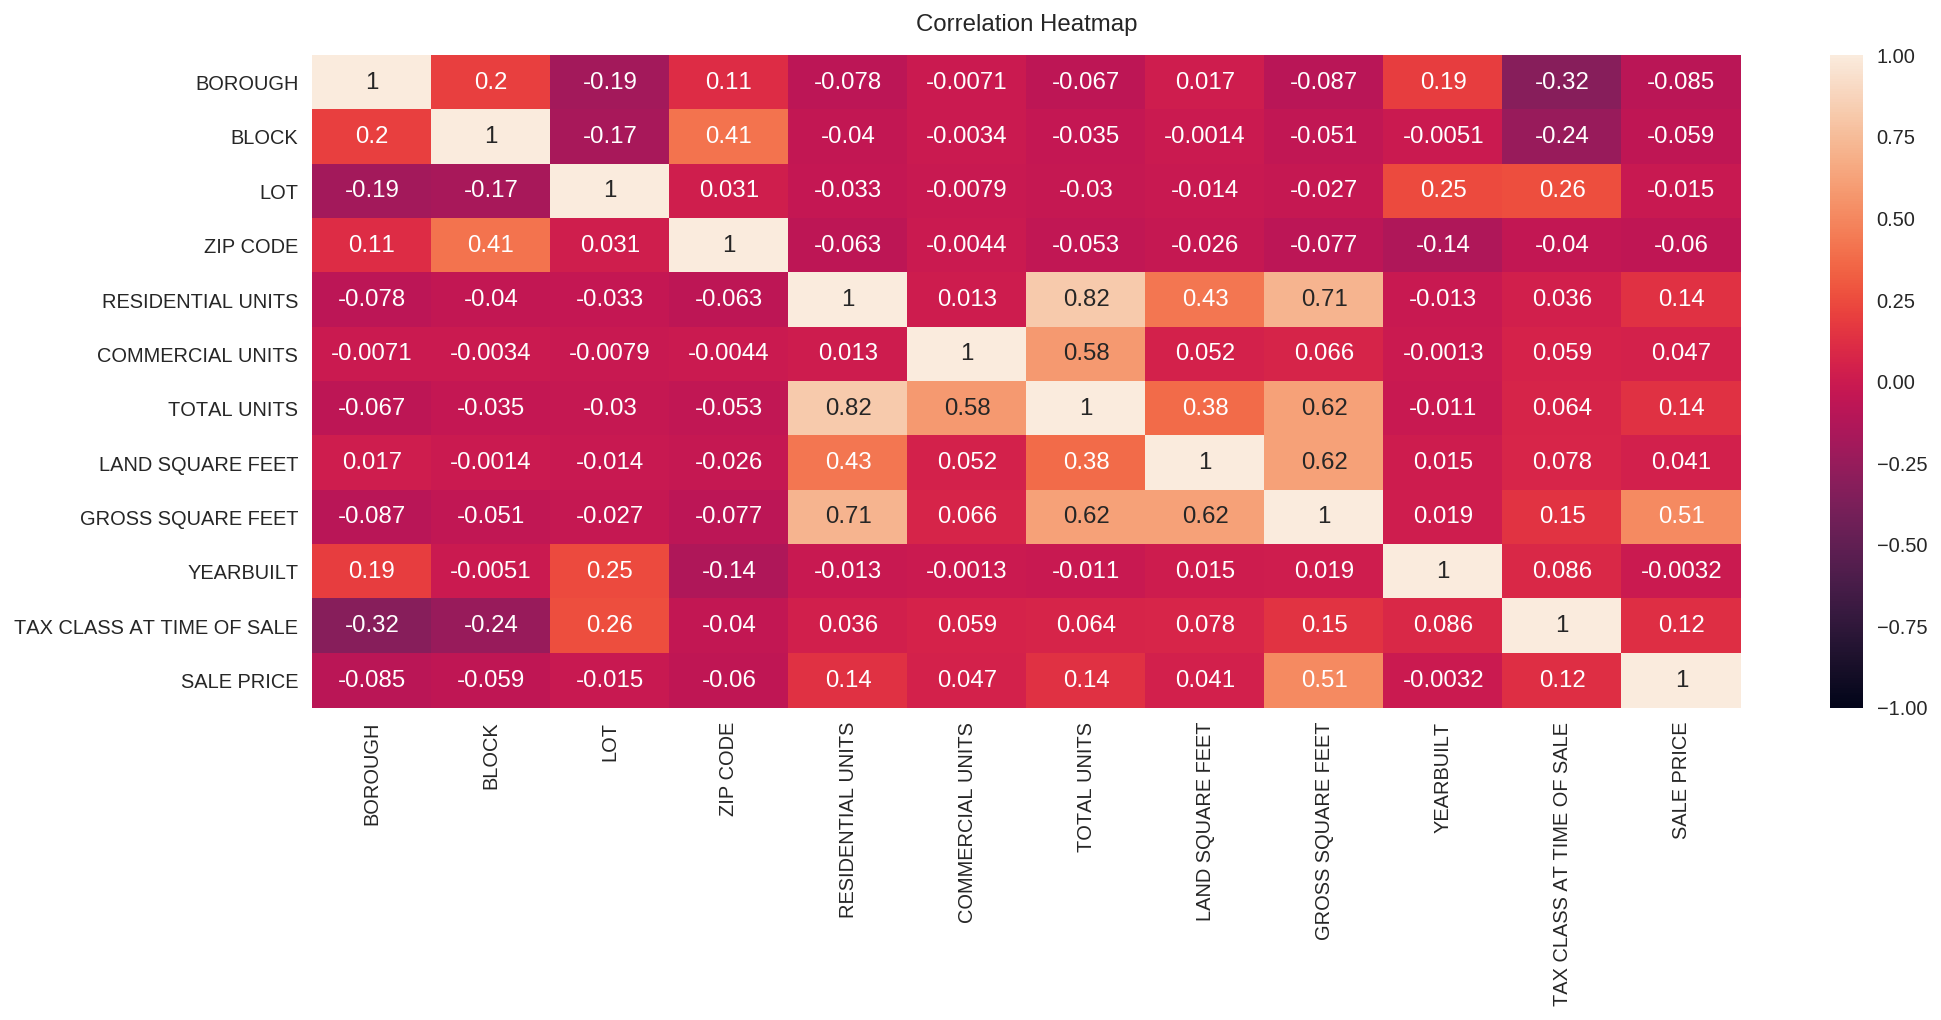

In [29]:
# Making a Heatmap to find correlation between features [2]
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(numerical_data.corr(), vmin=-1, vmax=1, annot=True)

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);



We observe that there exists a correlation between RESIDENTIAL UNITS and TOTAL UNITS at about 0.9, and a correlation between 
LAND SQUARE FEET and GROSS SQUARE FEET at about 0.7. These numbers indicate that we should only use one of the features when we design the model.
We therefore decide to drop LAND SQUARE FEET and RESIDENTIAL UNITS from or data. [3]


In [30]:
# 1. Remove columns with high correlation with other columns
df.drop(['LAND SQUARE FEET', 'RESIDENTIAL UNITS'], axis = 1, inplace=True)

#### 4.2 Outliers

Machine learning models are usually only as good as their inputs. Severe outliers in the dataset can make it hard for models to predict accurate values as they get confused by abnormal values. We therefore spend some time on exploring outliers and justify why we drop values that could be perfectly good data.

Inspiration for the plots are taken from this Kaggle report [4]

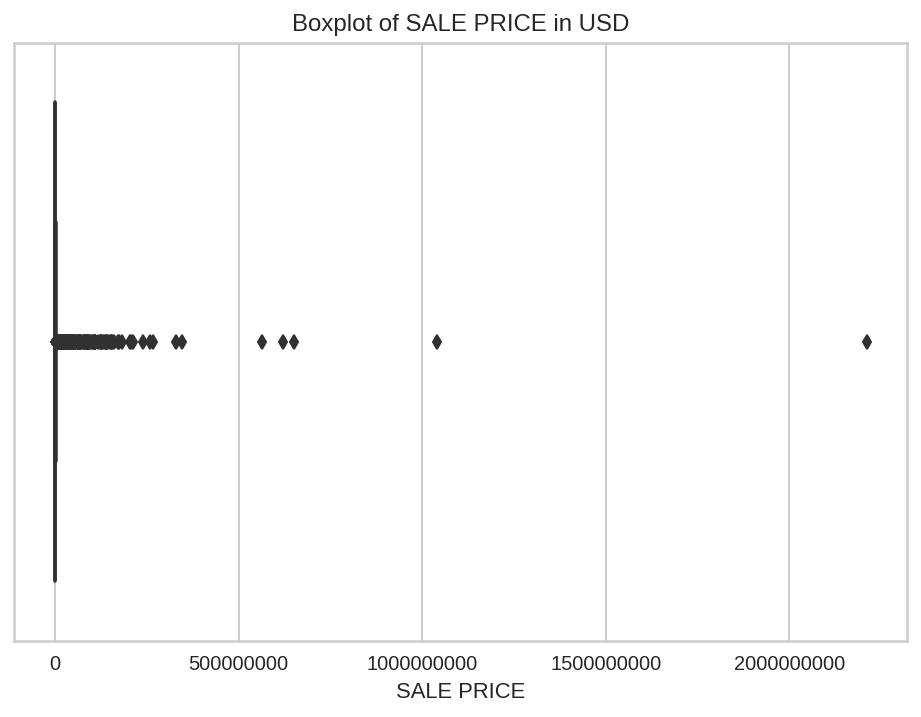

In [31]:
# outliers in SALE PRICE
sns.boxplot(x='SALE PRICE', data=df)
plt.ticklabel_format(style='plain', axis='x')
plt.title('Boxplot of SALE PRICE in USD')
plt.show()

We choose to visualize SALE PRICE in a boxplot. A boxplot shows the central value and its variability. We can see from the plot that it is hard to read something out of it. This is because we have some really high values. These outliers in SALE PRICE might interfere with our models and make lower or higher predictions based on abnormal data. Even though some of the very large sale prices might be correct they will probably confuse the model to much. We decide to remove values above 10 000 000 and less than 100 000.

In [32]:
# Dropping large and small values of SALE PRICE
large_sale_values = df[df['SALE PRICE'] > 10000000].index
df.drop(large_sale_values, inplace=True)

small_sale_values = df[df['SALE PRICE'] < 100000].index
df.drop(small_sale_values, inplace=True)

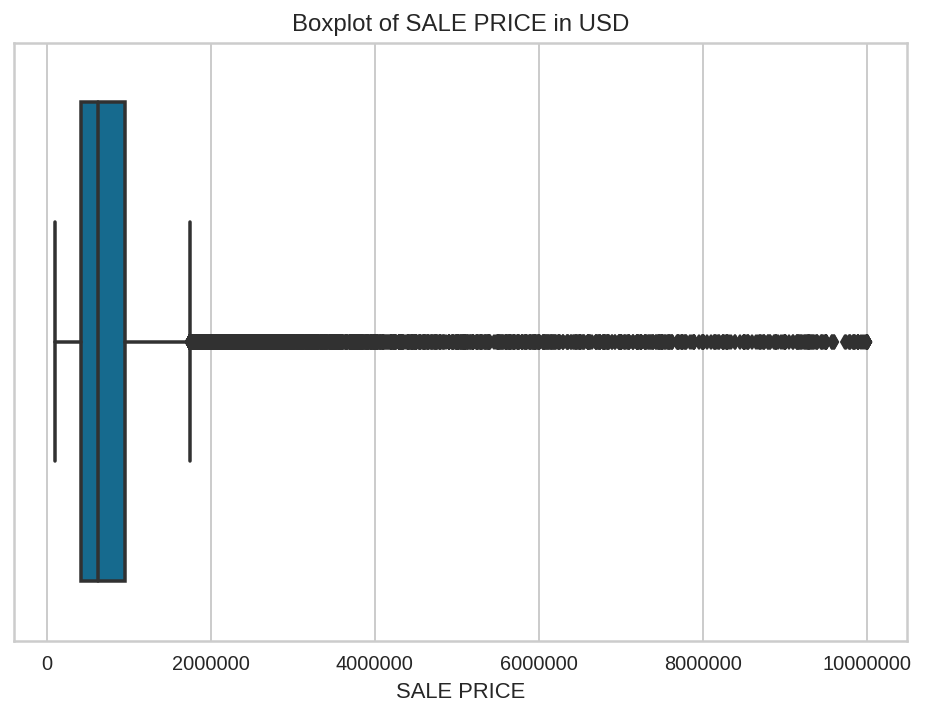

In [33]:
# Creating a new boxplot of SALE PRICE
sns.boxplot(x='SALE PRICE', data=df)
plt.ticklabel_format(style='plain', axis='x')
plt.title('Boxplot of SALE PRICE in USD')
plt.show()

Our new boxplot of SALE PRICE looks more balanced, but we still have some high values. We have a minimum value of 100 000, a median value around 700 000 and a maximum value of 10 000 000. We still have "outliers" in our data set according to our boxplot, but we believe that it would be a mistake to drop more values since house prices in NY can be very high.

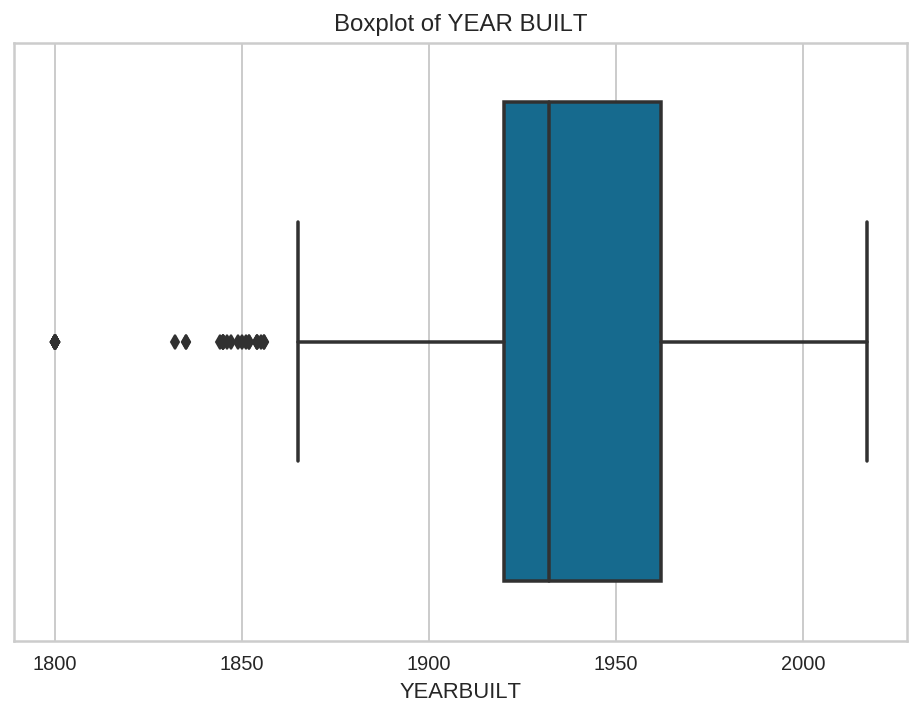

In [34]:
# Outliers in YEAR BUILT
sns.boxplot(x='YEARBUILT', data=df)
plt.ticklabel_format(style='plain', axis='x')
plt.title('Boxplot of YEAR BUILT')
plt.show()

We can see that there are some outliers in YEAR BUILT. The oldest building in New York still standing (fun fact: Wyckoff House in Canarsie) was built in 1652. Nevertheless, New York city had a period of rapid expansion from 1870 to 1930 and we can assume that most houses that are in use today were not built prior to 1800. We therefore decide to drop values prior to 1800 [16].

In [35]:
# Dropping values smaller than 1800
min_building_year = df[df['YEARBUILT'] < 1800].index
df.drop(min_building_year, inplace=True)

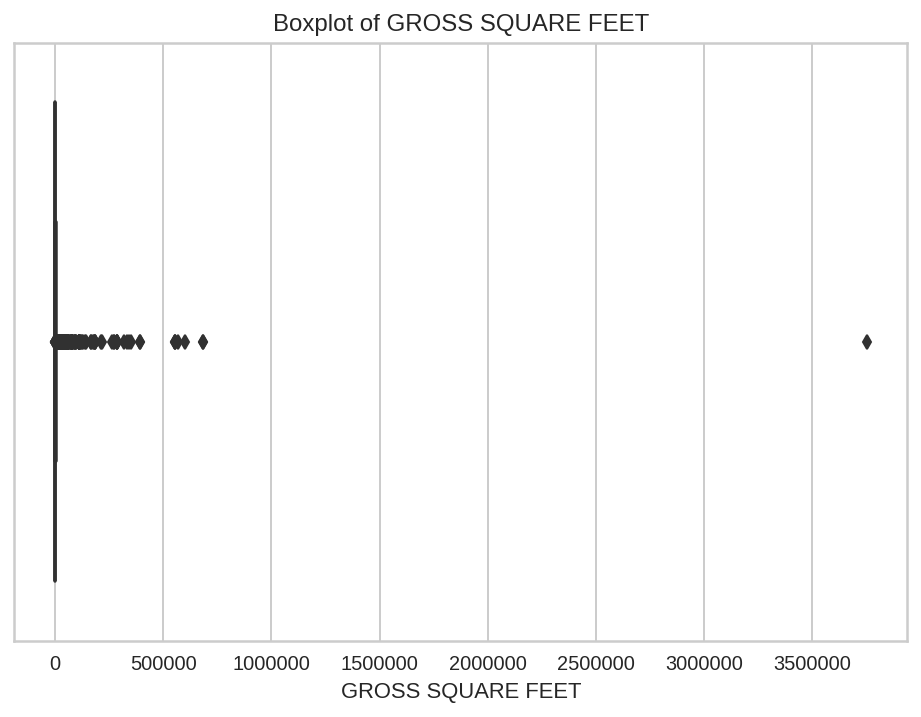

In [36]:
# Boxplot of Gross Square Feet
sns.boxplot(x='GROSS SQUARE FEET', data=df)
plt.ticklabel_format(style='plain', axis='x')
plt.title('Boxplot of GROSS SQUARE FEET')
plt.show()

We have some large values for GROSS SQUARE FEET and decide to drop very small and very large values. We drop values that are lower than 200 and higher than 40 000. 200 square feet converts to 18.5 m^2 and 40 000 square feet converts to 3716 m^2. We would argue that values higher or lower than this will be reasonable to drop.

In [37]:
# GROSS SQUARE FEET
large_properties = df[df['GROSS SQUARE FEET'] > 40000].index
df.drop(large_properties, inplace=True)

small_properties = df[df['GROSS SQUARE FEET'] < 200].index
df.drop(small_properties, inplace=True)

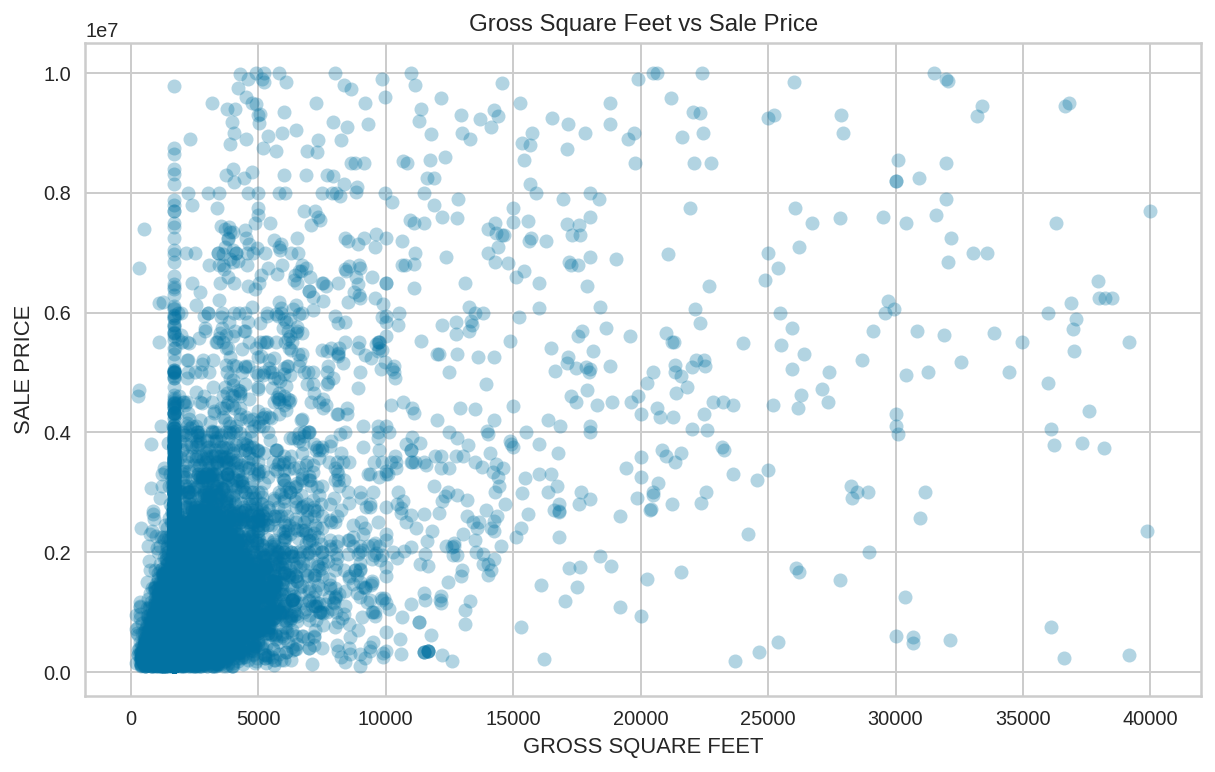

In [38]:
# Plot of SALE PRICE according to GROSS SQUARE FEET
plt.figure(figsize=(10,6))
sns.regplot(x='GROSS SQUARE FEET', y='SALE PRICE', data=df, fit_reg=False, scatter_kws={'alpha':0.3})
plt.title('Gross Square Feet vs Sale Price')
plt.show()

We would like to observe the correlation between Gross Square Feet and Sale price. As we can see from the plot Sale Price tends to increase with higher Gross square feet which one would have expected.

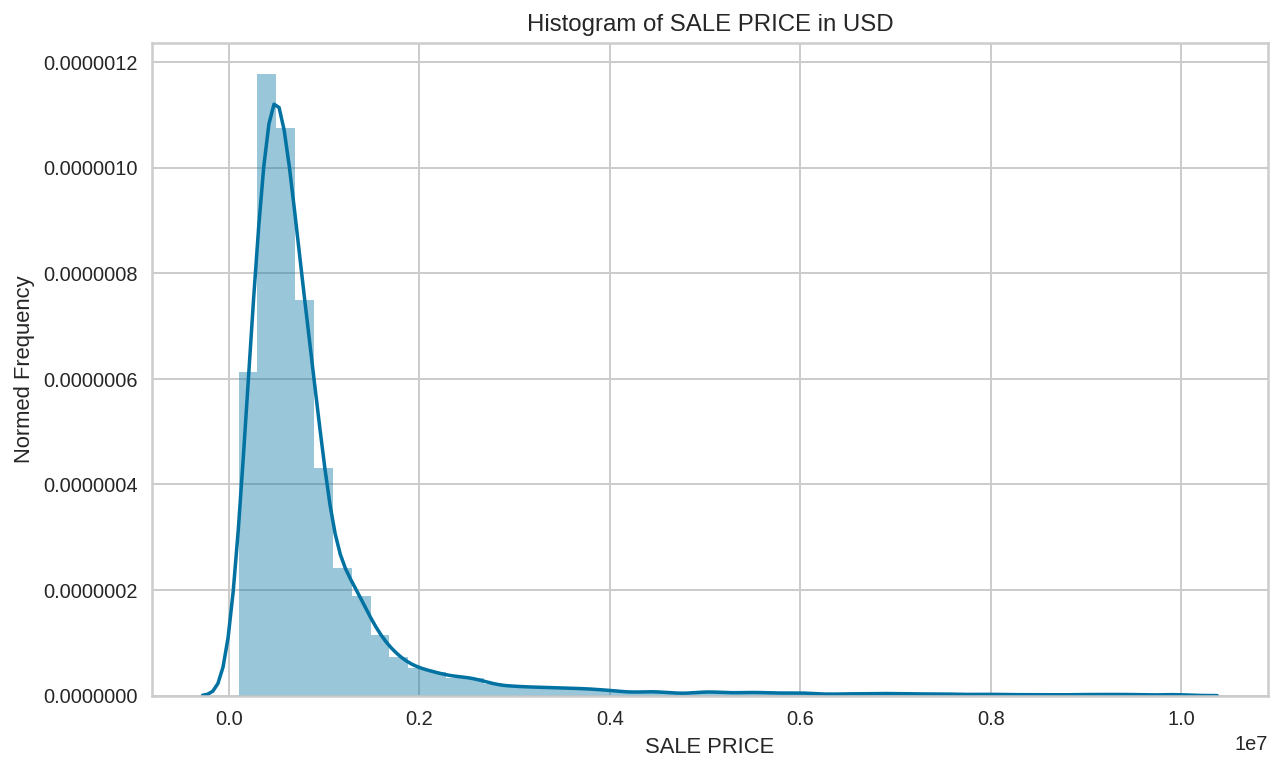

In [39]:
# Histogram of SALE PRICE
warnings.filterwarnings(action='ignore', category=FutureWarning)
plt.figure(figsize=(10,6))
sns.distplot(df['SALE PRICE'])
plt.title('Histogram of SALE PRICE in USD')
plt.ylabel('Normed Frequency')
plt.show()

Histogram plot of SALE PRICE to observe density. We can see that almost all our values are below 2 000 000 dollars. 

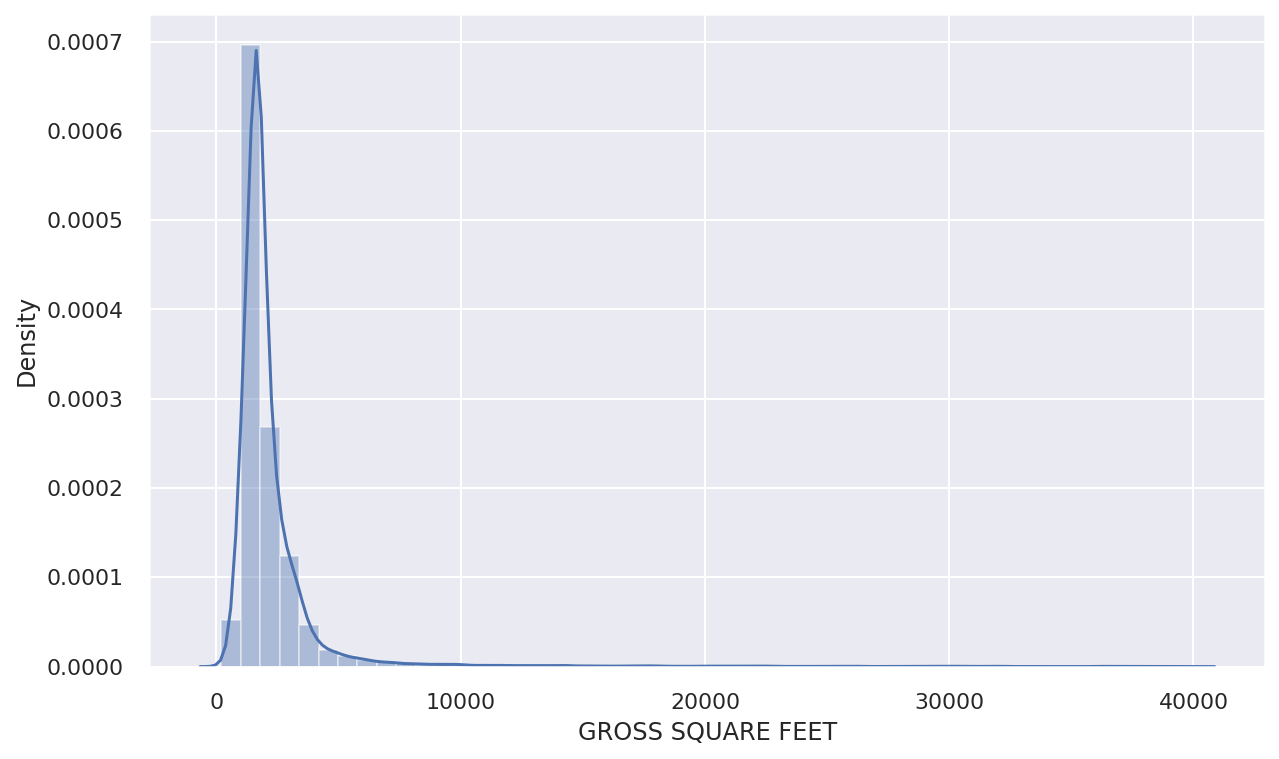

In [40]:
# Histogram of GROSS SQUARE FEET
sns.set(rc={"figure.figsize": (10, 6)}); np.random.seed(0)
x = df['GROSS SQUARE FEET']
ax = sns.distplot(x)
plt.show()

Histogram plot of GROSS SQUARE FEET to observe density. We can see from the plot that almost all our values are lower than 10000 square feet which converts to 929 m^2.

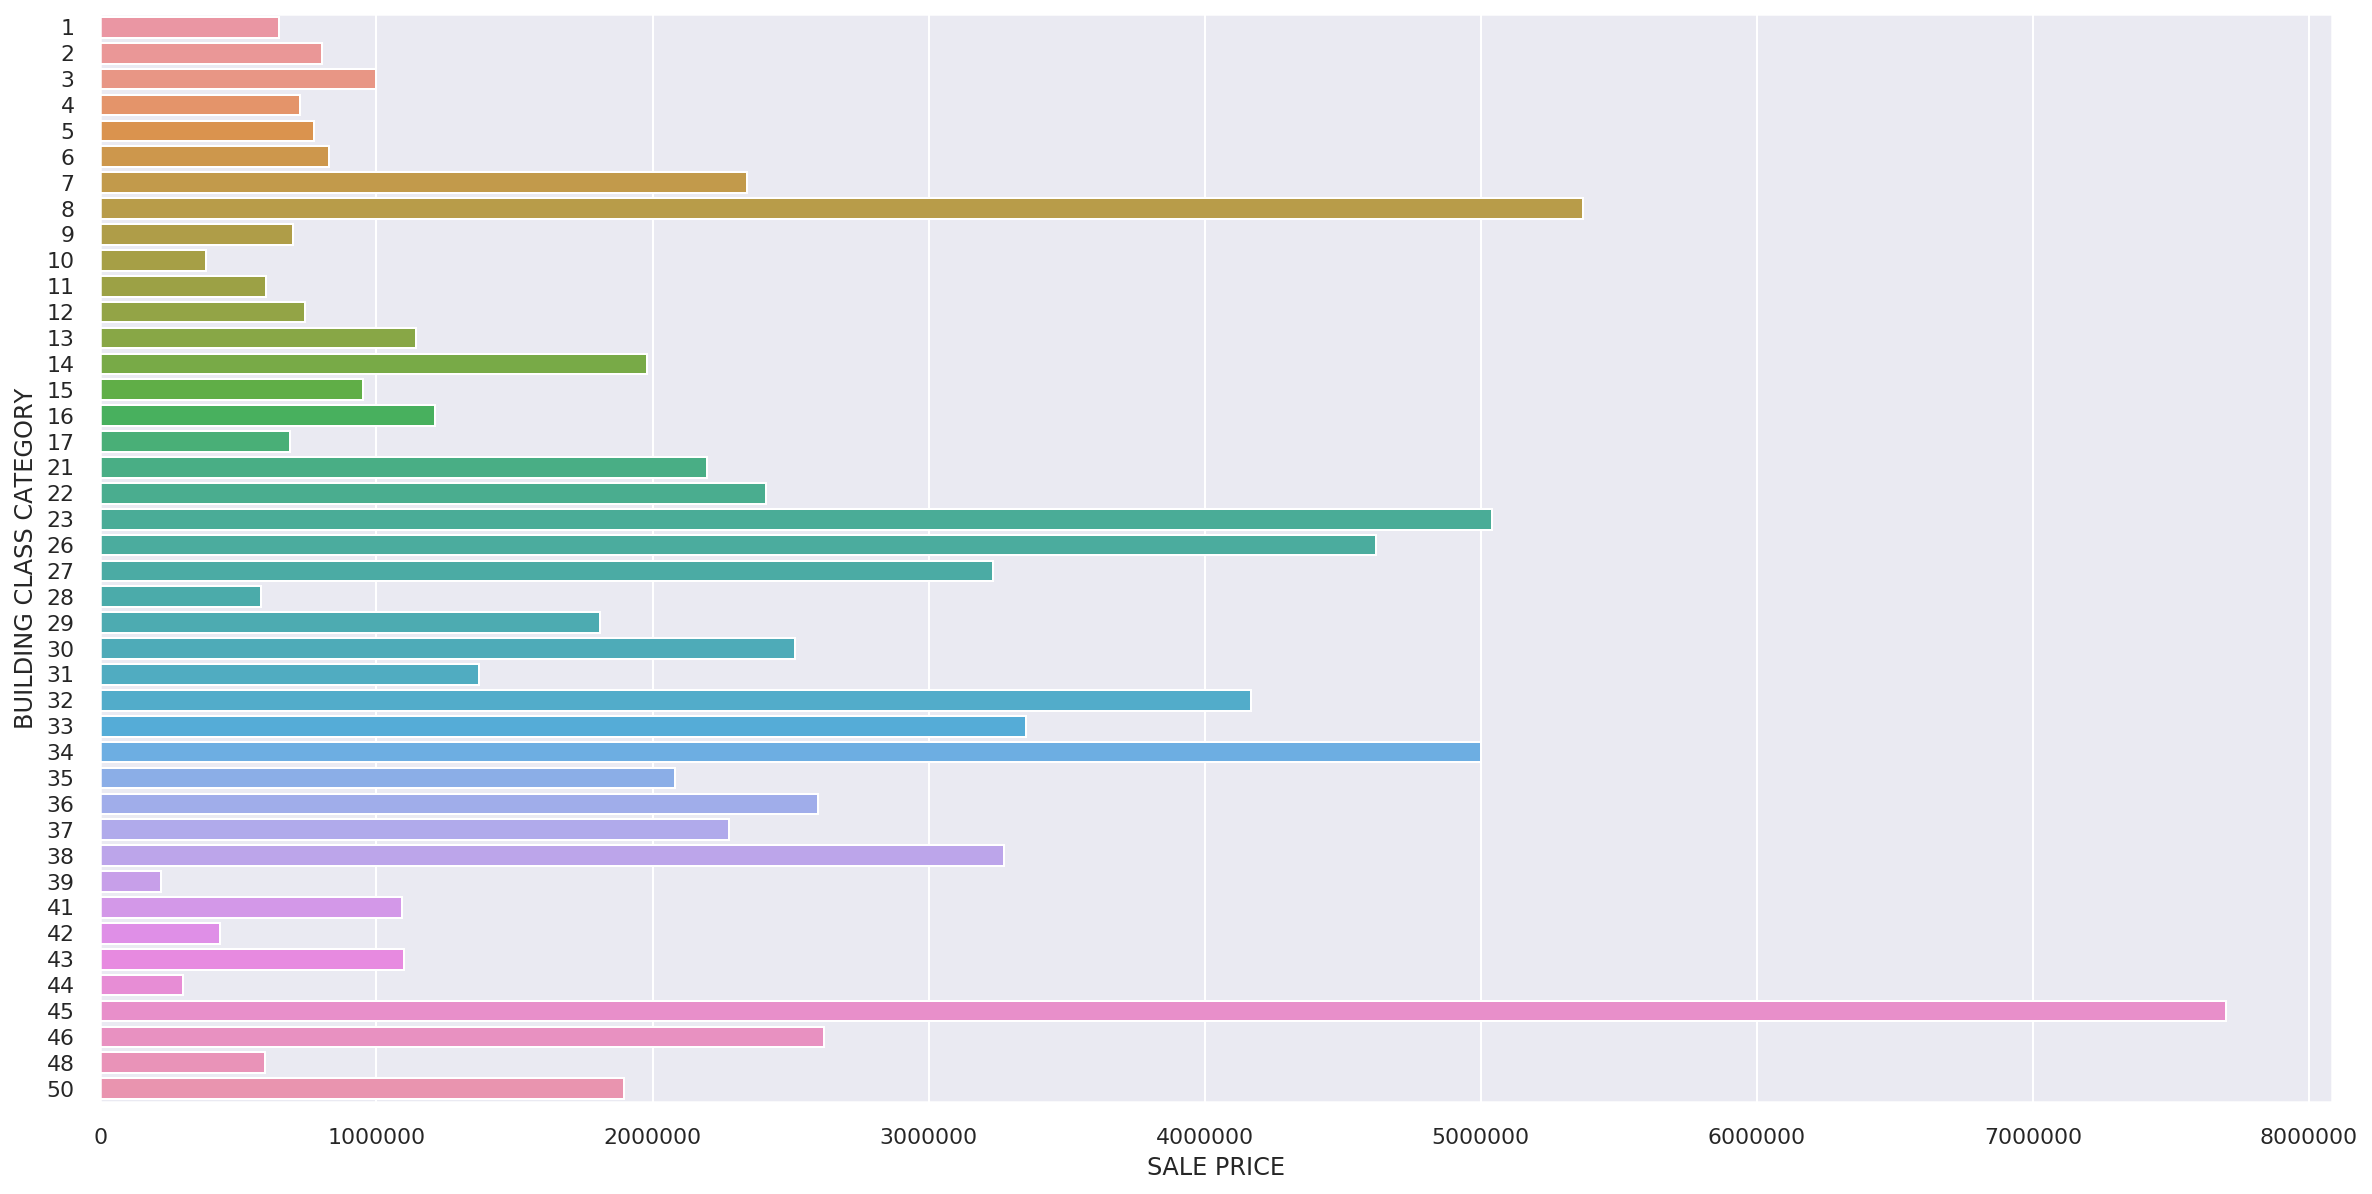

In [41]:
# Looking at the importance of values of Building class category to Sale Price. Retrived from [4]
cat=df[["BUILDING CLASS CATEGORY", "SALE PRICE"]].groupby(['BUILDING CLASS CATEGORY'], as_index=False).mean().sort_values(by='SALE PRICE', ascending=False)
plt.figure(figsize=(20,10))
sns.barplot(x='SALE PRICE', y='BUILDING CLASS CATEGORY', data=cat, orient = 'h')

We can read from the plot that building class number 8 and building class number 45 are building classes which tends to have a high SALE PRICE.

In [42]:
# Check if we're still missing something
print("Missing values in df =", sum(df.isna().sum())) 

print("Number of rows in dataset is :", len(df))

Missing values in df = 0
Number of rows in dataset is : 35352


#### 4.3 Analysis of data

In [43]:
df['BOROUGH']= df['BOROUGH'].replace({1:'Manhattan',2:'Bronx',3:'Brooklyn',4:'Queens',5:'Staten Island'})

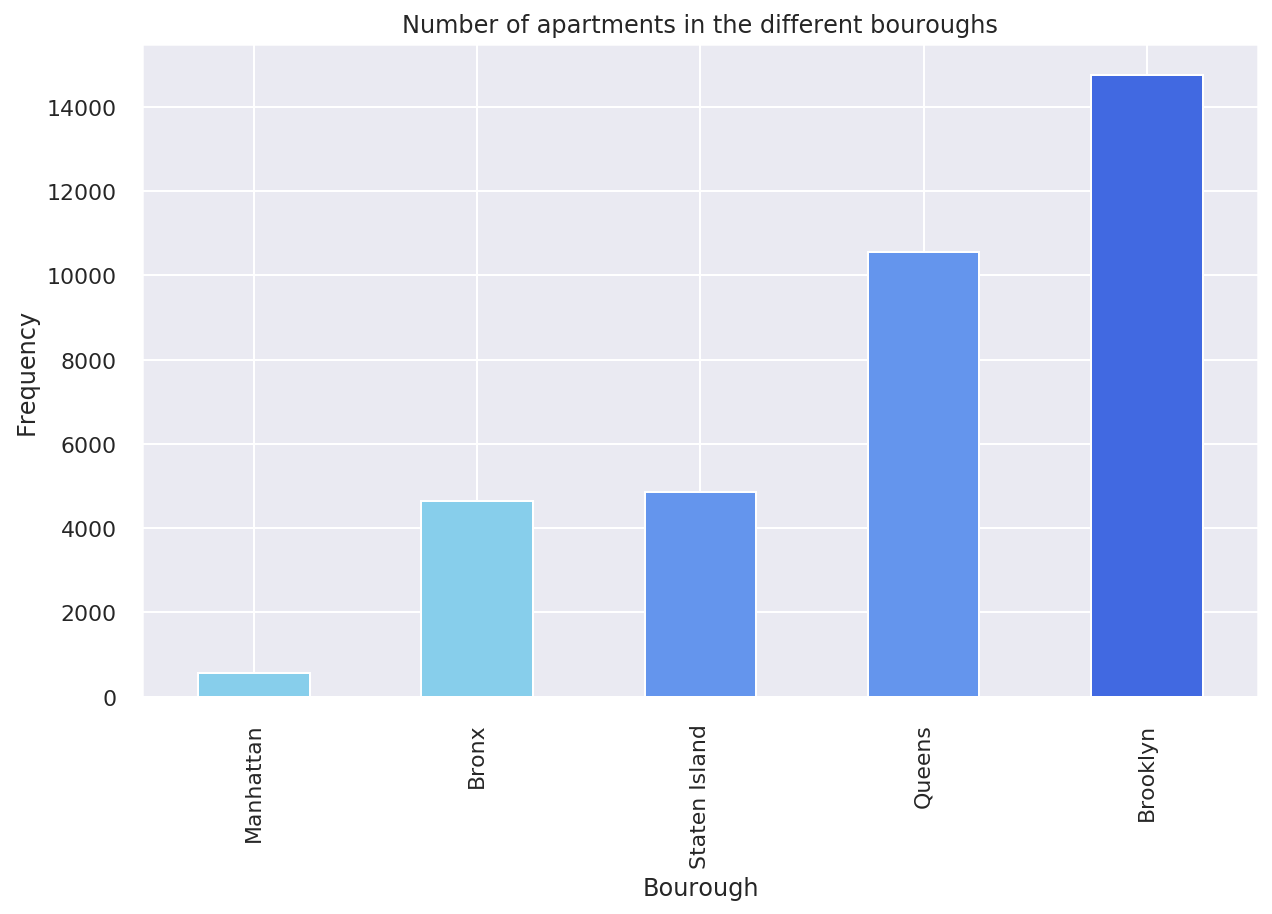

In [44]:
plt.ylabel("Frequency")
plt.xlabel("Bourough")
colors=['skyblue', 'skyblue', 'cornflowerblue', 'cornflowerblue', 'royalblue','blue','darkblue']
plt.title("Number of apartments in the different bouroughs")
df['BOROUGH'].value_counts().sort_values(ascending=True).plot(kind='bar', color=colors)
plt.show()

We have Boroughs with significantly more data points than others. This might be a problem for our model if Borough is an important explanatory factor. Fortunately, Borough does not seem to be a significant factor in SALE PRICE.

# 5. Running the algorithms
<a id='alg'></a>

### 5.1. K-Nearest Neighbor Regression
<a id='alg_knnreg'></a>

KNN Regression is a supervised machine learning algorithm which means that it maps labeled input to an output, and can be used to predict unlabeled output. The machine learning algorithm assumes data points closer to each other are similar. KNN regression calculates the distance between the data points to find its closest (most similar) "neighbors" and uses the information to predict an output [5].

In our data set we have properties with no corresponding Sale Price that we want to predict. It is plausible to think that properties with similar values regarding for example size and neighborhood will have a similar price. We therefore conclude that Knn Regression might be a good model for prediction in our data set

The independent variable in our Knn-Regression analysis is SALE PRICE. The independent variables are (11 variables): BOROUGH, NEIGHBORHOOD, BUILDING CLASS CATEGORY, BLOCK, LOT, ZIP CODE, TOTAL UNITS, GROSS SQUARE FEET, TAX CLASS AT TIME OF SALE, BUILDING CLASS AT TIME OF SALE, BUILDING AGE.

In [45]:
# 1. Copy dataframe and change type to category
kndata = df.copy()
kntarget = df['SALE PRICE']
kndata.drop(['SALE PRICE'], axis=1, inplace=True)
kndata = kndata.astype({"BOROUGH":'category', 'NEIGHBORHOOD': 'category', 'BUILDING CLASS AT TIME OF SALE': 'category'})

In [46]:
# 2. Categorical values to numerical values. Dropping YEARBUILT since we have AGE, and commercial units since the model seems to work better without it. Probarbly because of correlation with Total units
kndata['BOROUGH'] = kndata['BOROUGH'].cat.codes
kndata['NEIGHBORHOOD'] = kndata['NEIGHBORHOOD'].cat.codes
kndata['BUILDING CLASS AT TIME OF SALE'] = kndata['BUILDING CLASS AT TIME OF SALE'].cat.codes
kndata.drop(['YEARBUILT', 'COMMERCIAL UNITS'], axis = 1, inplace=True)
kndata['GROSS SQUARE FEET'] = kndata['GROSS SQUARE FEET'].astype(int)

In [47]:
#3. Checking that all values are numerical
kndata.dtypes

BOROUGH                            int8
NEIGHBORHOOD                      int16
BUILDING CLASS CATEGORY           int64
BLOCK                             int64
LOT                               int64
ZIP CODE                          int64
TOTAL UNITS                       int64
GROSS SQUARE FEET                 int64
TAX CLASS AT TIME OF SALE         int64
BUILDING CLASS AT TIME OF SALE    int16
BUILDING_AGE                      int64
dtype: object

In [48]:
# 4. Splitting data set. Setting test data to 20% and train data to 80%. There is no optimal splitting percentage, but 20/80 is common practice in machine learning
X_train, X_test, y_train, y_test = train_test_split(kndata, kntarget, random_state = 123, test_size = 0.2)

In [49]:
#5. Scaling the dataset between 0-1 with MinMax scaler. Tried both Standarsscaler and Minmax scaler, where Minmaxscaler gave better results. Will therefore proceed with MinmaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled)
X_test_scaled = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test_scaled)


In [50]:
# 6. Checking for the k number of neighbours that give the least Root-mean-suqare-error. Code is retrived from [11].
rmse_val = []
for K in range(0,20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train, y_train)  
    pred=model.predict(X_test)
    error = sqrt(mean_squared_error(y_test,pred))
    rmse_val.append(error)

    print('RMSE value for k= ' , K , 'is:', error)
    
min_val = min(rmse_val)
index = rmse_val.index(min_val)+1
print('\nThe best RMSE value for k= ' , index , 'is:', min_val)

RMSE value for k=  1 is: 809443.1161022563


RMSE value for k=  2 is: 735469.9646018826


RMSE value for k=  3 is: 702398.6686552353


RMSE value for k=  4 is: 674476.4697036067


RMSE value for k=  5 is: 665459.7310681695


RMSE value for k=  6 is: 664093.4649656995


RMSE value for k=  7 is: 658580.0648540895


RMSE value for k=  8 is: 654326.2540027337


RMSE value for k=  9 is: 654304.9609953277


RMSE value for k=  10 is: 654808.1878114027


RMSE value for k=  11 is: 656443.8994350302


RMSE value for k=  12 is: 659815.5577146114


RMSE value for k=  13 is: 660027.0316979471


RMSE value for k=  14 is: 662873.6702782402


RMSE value for k=  15 is: 665580.8364333563


RMSE value for k=  16 is: 668134.5951462826


RMSE value for k=  17 is: 668406.7759307086


RMSE value for k=  18 is: 669424.8595537675


RMSE value for k=  19 is: 669028.4447902561


RMSE value for k=  20 is: 667305.3333486203

The best RMSE value for k=  9 is: 654304.9609953277


In [51]:
# 7. Loading model and fitting the model with number of neighbors .
knmodel = KNeighborsRegressor(n_neighbors=index)
knmodel.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=9)

In [52]:
# 7. Predict the scores on X_test
predict = model.predict(X_test)

knn_result = pd.DataFrame({'Actual': y_test, 'Predicted': predict})
knn_result

,Actual,Predicted
28729,2300000.0,2781247.55
56632,795000.0,791378.00
6119,1090101.0,6271536.00
49235,985000.0,588414.30
44644,630995.0,912981.00
...,...,...
42512,280000.0,290456.50
23633,232000.0,359033.25
56182,860000.0,844225.00
49824,1150000.0,1093860.00


In [53]:
# 8. Print test scores
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predict))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, predict))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predict)))
KNN_score = round(knmodel.score(X_test_scaled, y_test)*100,2)
print('Training score:', knmodel.score(X_train_scaled, y_train))
print('Test score:', knmodel.score(X_test_scaled, y_test))
print('R2 score', r2_score(y_test, predict))
print('Score: ', KNN_score, '%')



Mean Absolute Error: 307695.33710931975
Mean Squared Error: 445296407915.51337
Root Mean Squared Error: 667305.3333486203


Training score: 0.7271693766103761


Test score: 0.563285842390164
R2 score 0.5457593080048124
Score:  56.33 %


The KNN regressor performs OK with a R2 score of 0.54. Testscore is 0.56 and training score is 0.72. This means that the KNN model overfits the data slightly, and does not perform as well when met with a new data set. Our model picks up on noise in the data making assumptions that is not actually there. Nevertheless, our model can explain 54 % of the predicted price estimate.

###### EXTRA: We tried to use one hot encoding and keep our columns categorical. This seems to be to take up to much memory for us to go forward with. We have therefore decided to use cat codes instead.

### 5.2. Random Forest Regression
<a id='alg_rfr'></a>

Ensembles of Decision Trees are methods that combine multiple machine learning models to create more powerful models. One of the two ensemble models that have proven to be effective on a wide range of datasets for classification and regression is random forests decision trees. [6]

We chose the random forest because it overfits less than any of the trees individually. We could use many
more trees (often hundreds or thousands), leading to even smoother boundaries. [6]

We choose the SALE PRICE column as our target value. And we drop columns COMMERCIAL UNITS, YEAR BUILT and BUILDING AGE as data.


In [54]:
# 1. Copy dataframe and change type to category
rfdata = df.copy()
rftarget = df['SALE PRICE']
rfdata.drop(['SALE PRICE'], axis=1, inplace=True)
rfdata = rfdata.astype({"BOROUGH":'category', 'NEIGHBORHOOD': 'category', 'BUILDING CLASS AT TIME OF SALE': 'category'})

In [55]:
# 2. Categorical values to numerical values like KNN model
rfdata['BOROUGH'] = rfdata['BOROUGH'].cat.codes
rfdata['NEIGHBORHOOD'] = rfdata['NEIGHBORHOOD'].cat.codes
rfdata['BUILDING CLASS AT TIME OF SALE'] = rfdata['BUILDING CLASS AT TIME OF SALE'].cat.codes
rfdata.drop(['YEARBUILT', 'COMMERCIAL UNITS'], axis = 1, inplace=True)
rfdata['GROSS SQUARE FEET'] = rfdata['GROSS SQUARE FEET'].astype(int)

In [56]:
# 3. Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(rfdata, rftarget, test_size = 0.2, random_state = 25)

In [57]:
# 4.Loading/fitting the model [14]
RF = RandomForestRegressor(n_estimators=100)
RF.fit(X_train,y_train)
print(RF)

RandomForestRegressor()


In [58]:
# 5.Printing the scores
print('Training score of Random forest:', round(RF.score(X_train, y_train)*100,2), "%")
RF_score = round(RF.score(X_test, y_test)*100,2)
print('Test score of Random forest:', RF_score, "%")


Training score of Random forest: 95.68 %


Test score of Random forest: 72.83 %



Residuals Plot


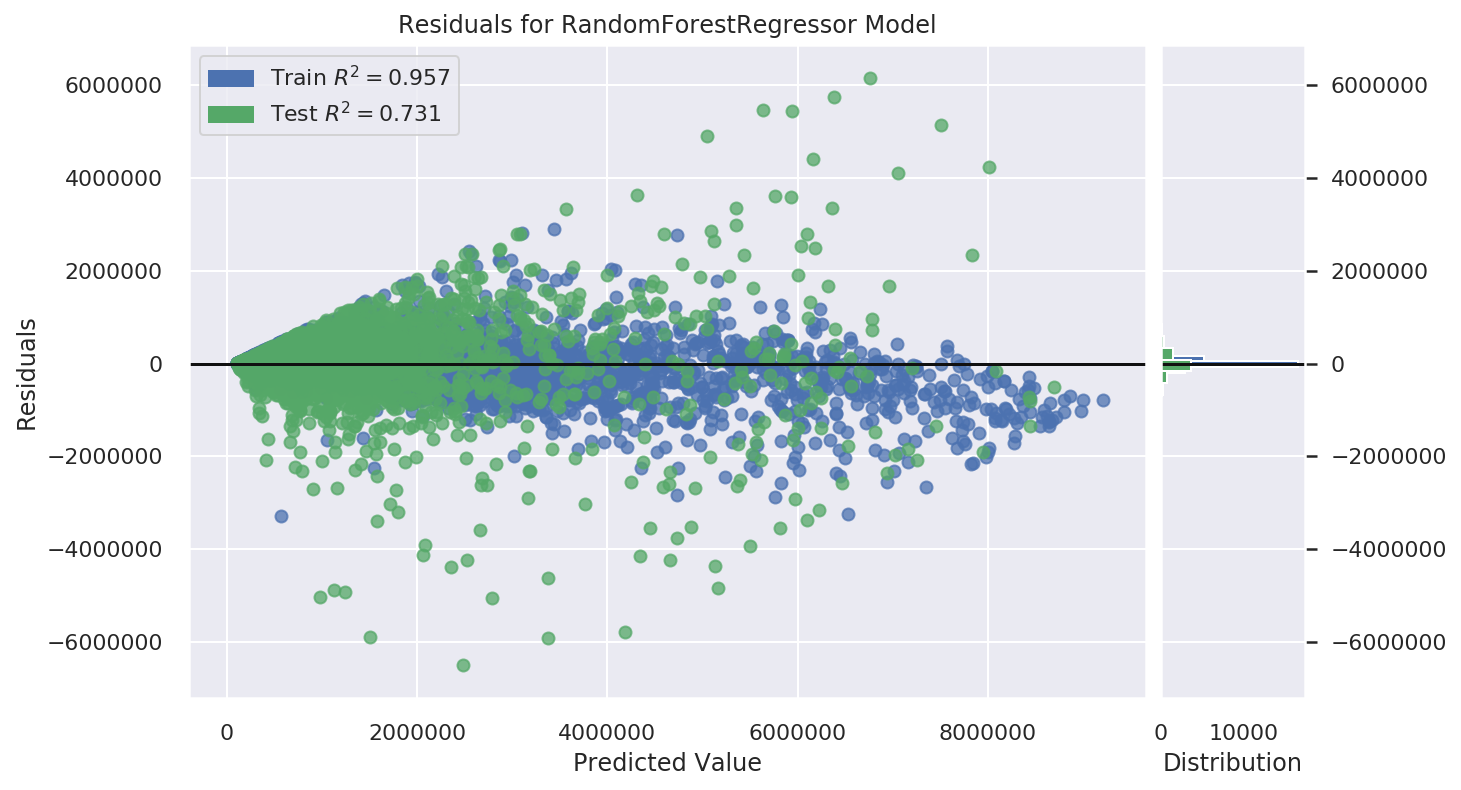

In [59]:
# 6.Create the visualizer, fit, score, and show it [15]
# Creating the Residuals Plot
print("\nResiduals Plot")
visualize = residuals_plot(RandomForestRegressor(), X_train, y_train, X_test, y_test)


Visualize the residuals between predicted and actual data for regression problems. A residual plot shows the residuals on the vertical axis and the independent variable on the horizontal axis. We can see that the points are not randomly dispersed around the horizontal axis so a non-linear model is more appropriate. [15]

A random forest is essentially a collection of decision trees, where each tree is slightly different from the others. [6]
As we can see, the random forest gives us a training score about 0.96 and test score about 0.73. This model provides better results than the linear models or a single decision tree, without tuning any parameters. However, the difference between training- and test scores does indicate a level of overfitting.



### 5.3. Linear Regression
<a id='alg_lr'></a>

Linear regression models are used to show the relationship between a *dependent variable* and one or more other variables, thus enabling us to predict the value of the dependent variable. In this instance, we will attempt to predict the **sale price** of a property by establishing a relationship between sale price and a number of other factors.

We have chosen to look at the relationship between sale price and building class, lot size, building age, and neighborhood. As shown in the plots above, we should be able to find a correlation and predict our dependent variable from them.

In [60]:
lrdata = df.copy()
lrmodel = LinearRegression()
lrmms = MinMaxScaler()

# Data selection and reshaping
lrdata = lrdata.astype({'NEIGHBORHOOD': 'category', 'BUILDING CLASS AT TIME OF SALE': 'category'})
lrdata['NEIGHBORHOOD'] = lrdata['NEIGHBORHOOD'].cat.codes
lrdata['BUILDING CLASS AT TIME OF SALE'] = lrdata['BUILDING CLASS AT TIME OF SALE'].cat.codes

lr_X = lrdata[['GROSS SQUARE FEET', 'BUILDING_AGE', 'NEIGHBORHOOD', 'BUILDING CLASS AT TIME OF SALE']]
lr_y = lrdata['SALE PRICE'].values.reshape(-1, 1)

# Train/Test split and fit
LRX_train, LRX_test, lry_train, lry_test = train_test_split(lr_X, lr_y, test_size=0.2, random_state=3)
lrmodel.fit(LRX_train, lry_train)

# Check predictions and show a random sample
lry_pred = lrmodel.predict(LRX_test)
lr_accuracy = pd.DataFrame({'Actual': lry_test.flatten(), 'Prediction': lry_pred.flatten()})
lr_accuracy.sample(10)

,Actual,Prediction
1540,585000.0,1.086973e+06
528,700000.0,6.473800e+05
3805,1600000.0,1.111339e+06
3634,485000.0,6.794275e+05
6228,3400000.0,1.072169e+06
5006,3618000.0,9.585792e+05
2943,420000.0,4.795441e+05
4235,784052.0,8.349586e+05
1733,604750.0,7.942909e+05
3054,660000.0,1.220350e+06


In [61]:
# Prediction metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(lry_test, lry_pred))
print('Mean Squared Error:', metrics.mean_squared_error(lry_test, lry_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(lry_test, lry_pred)))
LR_score = round(lrmodel.score(LRX_test, lry_test)*100,2)
print('Training score:', lrmodel.score(LRX_train, lry_train))
print('Test score:', lrmodel.score(LRX_test, lry_test))
print('R2 score', r2_score(lry_test, lry_pred))
print('Score: ', LR_score, '%')

Mean Absolute Error: 435403.33643795416
Mean Squared Error: 663374366634.5931
Root Mean Squared Error: 814477.9718535015
Training score: 0.3554613749730501
Test score: 0.3414852347864177
R2 score 0.3414852347864177
Score:  34.15 %


As we can see from our prediction score, the results are not great. There is clearly no way to draw a clear line through the data points as they are. After some adjustments and adding/removing of columns the best we seem to be able to do is roughly a 34% prediction accuracy (R2/Test). Training- and Test scores are almost identical, so there is very little over/under fitting. There are several factors that could be causing the low accuracy of the model:

1. We had to do a number of imputations due to missing values in the source data; these imputations may not be entirely accurate.
2. Housing prices are volatile and are influenced by a lot of factors that are not present in the data set at all, such as living trends, traffic patterns, zoning regulations, new developments etc.
3. While we have taken great care to remove or correct obviously incorrect values and extreme outliers, there may be errors that we were not able to catch and correct. We might have been able to increase the score somewhat by "massaging" the data further, but decided against it as we should not change the source data beyond correcting for obvious errors.

In order to increase prediction accuracy, we tried to use dummy features; this significantly increased processing time and resource consumption but ultimately lead to a negative R2 score, an issue we were not able to properly resolve.

### 5.4. Neural Network Models
<a id='alg_nn'></a>

Neural networks are supervised models that intend to imitate human learning capabilities via artificial neural networks, inspired by the human neural network architecture. Multilayer perception (MLP) can are commonly referred to as artificial neural networks. MLP is a combination of multiple neurons connected in the form a network. MLPs can be viewed as generalizations of linear models that perform multiple stages of processing to draw a conclusion. [6]

In our data set we will use Multilayer Perception Regressor (MLPRegressor) that trains using back-propagation with no activation function in the output layer, which can also be seen as using the identity function as activation function. Therefore, it uses the square error as the loss function, and the output is a set of continuous values. [7]

We choose the SALE PRICE column as target. And we drop columns COMMERCIAL UNITS, YEAR BUILT and BUILDING AGE as data.



In [62]:
# Neural Networks
nn_data = df.copy()
nn_target = nn_data['SALE PRICE']
nn_data.drop(['COMMERCIAL UNITS'], axis=1, inplace=True)
nn_data = nn_data.drop(['SALE PRICE'], 1)
nn_data = nn_data.astype({"BOROUGH":'category', 'BUILDING CLASS AT TIME OF SALE': 'category','NEIGHBORHOOD': 'category'})


In [63]:
# We use catcodes to get numerical values
nn_data['BOROUGH'] = nn_data['BOROUGH'].cat.codes
nn_data['NEIGHBORHOOD'] = nn_data['NEIGHBORHOOD'].cat.codes
nn_data['BUILDING CLASS AT TIME OF SALE'] = nn_data['BUILDING CLASS AT TIME OF SALE'].cat.codes
nn_data.drop(['YEARBUILT', 'BUILDING_AGE'], axis = 1, inplace=True)
nn_data['GROSS SQUARE FEET'] = nn_data['GROSS SQUARE FEET'].astype(int)

nn_data.dtypes

BOROUGH                            int8
NEIGHBORHOOD                      int16
BUILDING CLASS CATEGORY           int64
BLOCK                             int64
LOT                               int64
ZIP CODE                          int64
TOTAL UNITS                       int64
GROSS SQUARE FEET                 int64
TAX CLASS AT TIME OF SALE         int64
BUILDING CLASS AT TIME OF SALE    int16
dtype: object

In [64]:
# Scaling features given a minimum and maximum value between 0 and 1

scaler = MinMaxScaler()
scaler.fit(nn_data)
nn_data = scaler.transform(nn_data)

# Checking the results after scaling
print(nn_data)

[[0.5        0.00411523 0.12244898 ... 0.15678392 0.33333333 0.1171875 ]
 [0.5        0.00411523 0.12244898 ... 0.16567839 0.33333333 0.1328125 ]
 [0.5        0.00411523 0.12244898 ... 0.11092965 0.33333333 0.1171875 ]
 ...
 [1.         0.99176955 0.02040816 ... 0.05967337 0.         0.09375   ]
 [1.         0.99176955 0.02040816 ... 0.05469849 0.         0.09375   ]
 [1.         0.99176955 0.02040816 ... 0.03256281 0.         0.078125  ]]


In [65]:
# Loading the model. Train/test split [7]

# start running time
start = time.time()

X_train, X_test, y_train, y_test = train_test_split(nn_data, nn_target, random_state = 0)

nn = MLPRegressor( hidden_layer_sizes=[12,8,2],  activation='relu', solver='adam', alpha=0.0001, batch_size='auto',
                    learning_rate='constant', learning_rate_init=0.01, power_t=0.5, max_iter=2000, shuffle=True,
                    random_state=0, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
                    early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

# Print scores
nn.fit(X_train, y_train)
print(f'Training score for Neural network: {nn.score(X_train, y_train)*100:.2f} %')

nn.fit(X_test, y_test)
NN_score = round(nn.score(X_test, y_test)*100,2)
print (f'Test score for Neural network: {NN_score} %')

print(f'Current loss computed with the loss function: {nn.loss_}')
print(f'Number of iterations in the solver: {nn.n_iter_}')
print(f'Num of layers: {nn.n_layers_}')
print(f'Num of output: {nn.n_outputs_}')

# stop running time
stop = time.time()

#computing total running time
total = stop-start
print (f'Running time: {round(total/60)} minutes ')

Training score for Neural network: 62.25 %


Test score for Neural network: 61.09 %
Current loss computed with the loss function: 190872299050.93674
Number of iterations in the solver: 1256
Num of layers: 5
Num of output: 1
Running time: 4 minutes 


The Neural Network model takes some time to train and it was difficult to define the right layer size. We tried many combinations of layer quantity and layer size until we found the most satisfactory one.
This model provides a training score about 0,62 and test score about 0.61 so we can say that the model is not over- or under fitted on the training data. We would like to get a higher score, but the results are satisfactory.

### 5.5. Ridge Regression
<a id='alg_rr'></a>

Ridge regression is also a linear model, the formula used to make a prediction is the same as for OLS. However for ridge regression coefficients are chosen so they fit additional constraints as well as predict well on the training data. We decided to use L2 regularization which is a regularization technique that can be used to avoid overfitting. [8]

We choose SALE PRICE  as our target value. We dropped YEAR BUILT as we already have BUILDING AGE.

In [66]:
#Copying data frame
rrdata = df.copy()
#Choosing target value and dropping it
rrtarget = rrdata['SALE PRICE']
rrdata = rrdata.drop(['SALE PRICE'], 1)
#Changing type to categorical so we can convert to numerical
rrdata = rrdata.astype({"BOROUGH":'category', 'NEIGHBORHOOD': 'category', 'BUILDING CLASS AT TIME OF SALE': 'category'})

In [67]:
#Converting categorical data to numerical values. Dropping 'YEAR BUILT' as we already have 'BUILDING_AGE'. No other values are being dropped as it seems to have little effect on the outcome.
rrdata['BOROUGH'] = rrdata['BOROUGH'].cat.codes
rrdata['NEIGHBORHOOD'] = rrdata['NEIGHBORHOOD'].cat.codes
rrdata['BUILDING CLASS AT TIME OF SALE'] = rrdata['BUILDING CLASS AT TIME OF SALE'].cat.codes
rrdata.drop(['YEARBUILT'], axis = 1, inplace=True)
rrdata['GROSS SQUARE FEET'] = rrdata['GROSS SQUARE FEET'].astype(int)


In [68]:
#Checking that the datatypes of rrdata has been converted
rrdata.dtypes

BOROUGH                            int8
NEIGHBORHOOD                      int16
BUILDING CLASS CATEGORY           int64
BLOCK                             int64
LOT                               int64
ZIP CODE                          int64
COMMERCIAL UNITS                  int64
TOTAL UNITS                       int64
GROSS SQUARE FEET                 int64
TAX CLASS AT TIME OF SALE         int64
BUILDING CLASS AT TIME OF SALE    int16
BUILDING_AGE                      int64
dtype: object

In [69]:
X_train, X_test , y_train, y_test = train_test_split(rrdata, rrtarget, test_size=0.25, random_state=1)

In [70]:
#Here we use L2 regularization to find the most optimal alpha. The alpha specifies how much importance the model places on simplicity versus training set performance. [8]

#This list maintains the different cross-validation scores
cross_val_scores_ridge = []
#This list maintains the different values of alpha
alpha = []

# Loop to compute the different values of cross-validation scores. Our interval for the alpha is 0.25 in the range 1 to 10.
for i in range(1, 10):
    ridgeModel = Ridge(alpha = i * 0.25)
    ridgeModel.fit(X_train, y_train)
    scores = cross_val_score(ridgeModel, rrdata, rrtarget, cv = 10)
    avg_cross_val_score = mean(scores)
    cross_val_scores_ridge.append(avg_cross_val_score)
    alpha.append(i * 0.25)

In [71]:
# Loop that prints the different values of cross-validation scores
for i in range(0, len(alpha)):
    print(str(alpha[i])+' : '+str(cross_val_scores_ridge[i]))

0.25 : -19.91687713081389
0.5 : -19.916449743669
0.75 : -19.91602195067612
1.0 : -19.91559375220821
1.25 : -19.915165148637733
1.5 : -19.914736140336977
1.75 : -19.91430672767787
2.0 : -19.91387691103192
2.25 : -19.91344669077044


In [72]:
#The difference is slight, but an alpha of 0.25 gives us a slightly better score
ridge = Ridge(alpha=0.25).fit(X_train, y_train)
print("Training set score: {:.2f}".format(ridge.score(X_train, y_train)))
Ridge_score = round(ridge.score(X_test, y_test)*100,2)
print("Test set score for ridge is:", Ridge_score, "%")

Training set score: 0.40
Test set score for ridge is: 39.1 %


The ridge model gives us a training score of 40% and a test score of 39.1%. As expected the ridge model gives very similar results for the training and test. Compared to linear regression the ridge model "shrinks" coefficients towards zero, and on this data set it gives about a 5% points better score on the test data compared to linear regression. To find the most optimal alpha we use the loop shown above and display these using another loop displaying the cross-validation-score and the relating alpha.

### 5.7. XGBOOST Regression
<a id='alg_xgb'></a>

We have decided to run an extreme gradient boosting for regression in our analysis. It was developed by Tianqi Chen in 2016 and was designed to be efficient and highly effective. Gradient boosting refers to a class of group machine learning algorithms that can be used for both classification and regression problems. It is constructed from decision tree models. Trees are added one at a time to the group and fit to correct the prediction errors made by prior models. This type of model is classified as boosting. These models are fitted using loss functions and gradient descent optimization algorithms which give us “gradient boosting" [9]

In [73]:
# Make data and target values
XG_data = df
XG_target = XG_data['SALE PRICE']
XG_data = XG_data.drop(['SALE PRICE'], 1)
XG_data = XG_data.astype({"BOROUGH":'category', 'NEIGHBORHOOD': 'category', 'BUILDING CLASS AT TIME OF SALE': 'category'})
# Categorical values to numerical values. Dropping YEAR BUILT since we have AGE, and commercial units since the model seems to work better without it. Probarbly because of multicollinarity with Total units
XG_data['BOROUGH'] = XG_data['BOROUGH'].cat.codes
XG_data['NEIGHBORHOOD'] = XG_data['NEIGHBORHOOD'].cat.codes
XG_data['BUILDING CLASS AT TIME OF SALE'] = XG_data['BUILDING CLASS AT TIME OF SALE'].cat.codes
XG_data.drop(['YEARBUILT', 'COMMERCIAL UNITS'], axis = 1, inplace=True)
XG_data['GROSS SQUARE FEET'] = XG_data['GROSS SQUARE FEET'].astype(int)

In [74]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(XG_data, XG_target, random_state = 123)

In [75]:
# Transforming the data into a XGBOOSt matrix
dtrain = xgboost.DMatrix(X_train, label=y_train)
dtest = xgboost.DMatrix(X_test, label=y_test)

In [76]:
# The next part of the code generated a Warning for using sliced data. This error seemed to be common while using XGBOOSt so we have chosen to ignore it.
warnings.filterwarnings(action='ignore', category=UserWarning)

Grid Search is a method to tune the hyper-parameters in a model. We choose a range of values for our parameters and feed it to the Grid search to  predict what values give us the lowest RMSE [12].

In [77]:
# Implementing Grid Search to find the best parameters for our model. We have chosen too predict learning_rate, max_depth and reg_alpha. Optimally we would check for all paramters, but this takes too much time and space to be done here [13]

dmatrix = xgboost.DMatrix(X_train, y_train)

# Grid Search Parameters
grid_search_params = {
    'learning_rate': [0.01, 0.1, 0.2, 0.5],
    'max_depth': [2, 3, 5, 6],
    'reg_alpha': [0.01, 0,1, 2],
}

xg_grid_reg = xgboost.XGBRegressor(objective= "reg:squarederror")

grid = GridSearchCV(estimator=xg_grid_reg, param_grid=grid_search_params, scoring='neg_mean_squared_error',
                    cv=5, verbose=1 )

grid.fit(X_train, y_train)
print("GridSearchCV")
print("Best parameters found: ", grid.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid.best_score_)))

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV
Best parameters found:  {'learning_rate': 0.2, 'max_depth': 6, 'reg_alpha': 2}
Lowest RMSE found:  547049.862290357


In [78]:
# Looking at scores from Grid Search [12]
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: -299263551831.898621 using {'learning_rate': 0.2, 'max_depth': 6, 'reg_alpha': 2}
-747139342104.790771 (24304742271.370529) with: {'learning_rate': 0.01, 'max_depth': 2, 'reg_alpha': 0.01}
-747139342104.790771 (24304742271.370529) with: {'learning_rate': 0.01, 'max_depth': 2, 'reg_alpha': 0}
-747139344188.649170 (24304743812.012238) with: {'learning_rate': 0.01, 'max_depth': 2, 'reg_alpha': 1}
-747139344226.314819 (24304743787.780388) with: {'learning_rate': 0.01, 'max_depth': 2, 'reg_alpha': 2}
-674590514093.783081 (23868027474.255489) with: {'learning_rate': 0.01, 'max_depth': 3, 'reg_alpha': 0.01}
-674590514093.783081 (23868027474.255489) with: {'learning_rate': 0.01, 'max_depth': 3, 'reg_alpha': 0}
-674590513571.937744 (23868026820.738792) with: {'learning_rate': 0.01, 'max_depth': 3, 'reg_alpha': 1}
-674590515787.682007 (23868026840.028942) with: {'learning_rate': 0.01, 'max_depth': 3, 'reg_alpha': 2}
-602918003413.974365 (23957867462.538601) with: {'learning_rate': 0.01, 'm

In [79]:
XGmodel = xgboost.XGBRegressor(max_depth = 6, learning_rate = 0.2, reg_alpha = 2)
XGmodel.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=3, num_parallel_tree=1, random_state=0,
             reg_alpha=2, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [80]:
# Looking at loss function
print(XGmodel.objective)

reg:squarederror


We can see that we have selected squarederror as Lossfunction. Loss function is a measure of how good a prediction model does in terms of being able to predict the expected outcome [10] [17].

In [81]:
# Predicting model
predict = XGmodel.predict(X_test)

In [82]:
# Looking at the score for the model
print('Training score for XGBOOST-regression is:', XGmodel.score(X_train, y_train))
XgBoost_score = round(XGmodel.score(X_test, y_test)*100,2)
print('Test score for XGBOOST-regression is:', XgBoost_score, "%")
r2 = r2_score(y_test, predict)
rms = sqrt(mean_squared_error(y_test, predict))
print('RMS score for XGBOOST-regression is', rms)
print('R2 score for XGBOOST-regression is', r2)

Training score for XGBOOST-regression is: 0.8894503001573113
Test score for XGBOOST-regression is: 68.38 %
RMS score for XGBOOST-regression is 566039.7201265832
R2 score for XGBOOST-regression is 0.683789569609216


In [83]:
XGBoost_accuracy = pd.DataFrame({'Actual': y_test, 'Prediction': predict})
XGBoost_accuracy.sample(10)

,Actual,Prediction
70888,1350000.0,1.128688e+06
78709,330000.0,6.145874e+05
28156,1150000.0,1.139531e+06
56856,965000.0,1.013438e+06
74092,473000.0,4.215227e+05
46030,955000.0,8.888899e+05
80444,530000.0,4.908277e+05
25271,765000.0,5.435974e+05
13468,8000000.0,6.760170e+06
53238,860000.0,8.080032e+05


THe XGBoost model provides a training score of approximately 88% and a test score of 68% This means that the model is overfitted on the test data. We should maybe have simplified even more to prevent our model from being overfitted. We also tried XGBoost with one-hot encoding. We fitted the model with 456 featured using pd.get_dummies and scaled the numerical features. From there on we used the same method as above. This did not give us a better score so we decided to stick with the method stated above

## 6. Evaluation
<a id='eval'></a>

We have built and evaluated 6 different models predicting house prices in NY city. Based on the test scores  we can evaluate the models.

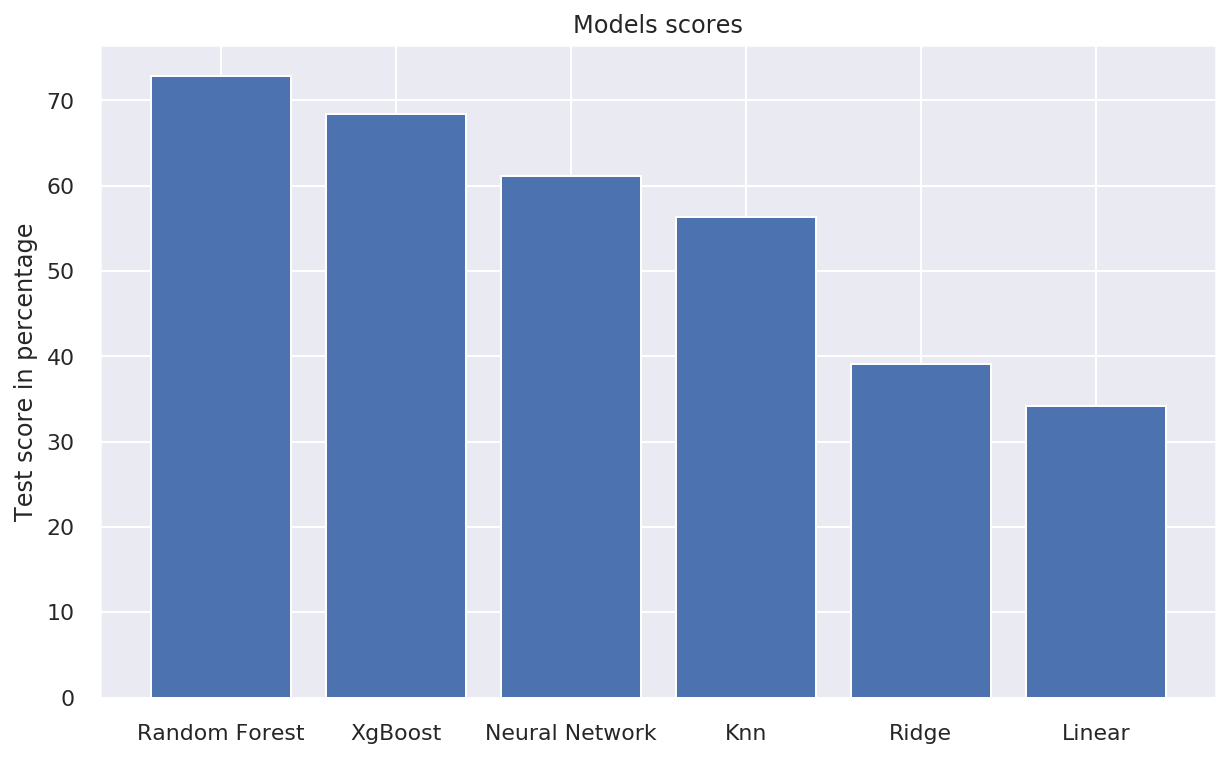

In [84]:
# Plotting the scores [8]
Test_scores = [RF_score, XgBoost_score, NN_score, KNN_score, Ridge_score, LR_score]

models = ['Random Forest','XgBoost', 'Neural Network','Knn', 'Ridge','Linear']

plt.bar(models, Test_scores)
plt.title('Models scores')
plt.ylabel('Test score in percentage')
plt.show()


We can read from the barchart Random Forest and XgBoost are our best models. Our best model, Random Forest has a test score of 0.73 and our worst performing model Linear regression has a test score of 0.34. Hence, there is a difference of 0.39 from or worst and our best performing model.

It is also worth noting that our best predicting models where both tree-based and that this algorithm type probably works best with our data. Our worst performing algorithms Ridge and simple linear Regression are both types of linear regressions. Ridge regression is usually better at not overfitting the data and predicts a better score than simple linear regression in our project. It is plausible to think that linear regression is too simple to predict good scores and this is also shown in our scores.

Thoughts in the end:
- In the beginning of our preprocessing we imputed median values for Gross Square feet and Land square feet, mode values for Year Built and the most common Zip code in neighborhood for Zip Code. We could have dropped the values or imputed all the values with Regressionimputer. If this is a weakness or a strength of our project is hard to say, but seeing that we can argue for our imputations we find it better to have kept the rows than to have dropped them.
- Optimally we should have done more complex Grid Searches, but seeing that it takes a lot of time and capacity we have stuck with a few values.
- We tried to keep the categorical columns as category type and used one-hot encoding. This worked for some of the algorithms but gave us a lower or equal score. With the growing number of features, implementing grid search seemed to be too much for our program. We have therefore decided to stick with using numerical columns instead.
- Looking for outliers we used visualizations and common sense to trim our dataset. We have probably trimmed away perfectly good data. The trimming of the dataset has definitely impacted our predictions to the better, but whether we set the cut off at the best value or not is hard to predict.
- We could have tried to use the logarithm of SALE PRICE and GROSS SQUARE FEET to get data with a more normal distribution


### 7. Sources
<a id='sources'></a>

[1] Silaparasetty (2020) Guide to Handling Missing Values in Data Science? Retrived April 14,2021 from
https://medium.com/@vinitasilaparasetty/guide-to-handling-missing-values-in-data-science-37d62edbfdc1

[2] Szabo, B. (2020). How to Create a Seaborn Correlation Heatmap in Python? Retrieved April 14, 2021 from https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e

[3] Yssou, A (2020). NYC Property Sales. Kaggle. Retrieved March 30, 2021 from https://www.kaggle.com/arielyssou/nyc-property-regression

[4] Dhillon, S.M.(2020). Business analysis report#4. Kaggle. Retrieved March 31, 2021 from https://www.kaggle.com/jatta3399/business-analysis-report-4

[5] Harrison Onel, 2018, TowardsDataScience, "Machine Learning Basics with the K-Nearest Neighbors Algorithm", link:https://towardsdatascience.com/machine-learning-basics-with-the-k-nearest-neighbors-algorithm-6a6e71d01761

[6] Guido S., Müller A.,2017, "Introduction to Machine Learning with Python: A Guide for Data Scientists". Published by O’Reilly Media.

[7] Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011. "1.17. Neural network models (supervised)", link: https://scikit-learn.org/stable/modules/neural_networks_supervised.html

[8] Gupta, A. (2019). ML | Implementing L1 and L2 regularization using Sklearn. GeeksforGeeks. Retrieved April 24, 2021 from https://www.geeksforgeeks.org/ml-implementing-l1-and-l2-regularization-using-sklearn/

[9] Brownlee, J. (2021) XGBoost for Regression. Machine Learning Mastery. Retrieved April 20, 2021 from 
https://machinelearningmastery.com/xgboost-for-regression/

[10] Grover, P. (2018) 5 Regression Loss Functions All Machine Learners Should Know. HeartBeat. Retrieved April 29, 2021 from https://heartbeat.fritz.ai/5-regression-loss-functions-all-machine-learners-should-know-4fb140e9d4b0

[11] Singh , A.(2018)  Practical Introduction to K-Nearest Neighbors Algorithm for Regression(with Python code). Retrieved May 06, 2021 from https://www.analyticsvidhya.com/blog/2018/08/k-nearest-neighbor-introduction-regression-python/

[12] Brownlee, J. (2020) Tune Learning Rate for Gradient Boosting with XGBoost in Python. Machine Learning Mastery. Retrieved May 06, 2021 from https://machinelearningmastery.com/tune-learning-rate-for-gradient-boosting-with-xgboost-in-python/

[13] Malik, S. (2020) XGBoost: A Deep Dive Into Boosting. Retrived May 06, 2021 from https://dzone.com/articles/xgboost-a-deep-dive-into-boosting

[14] sklearn.ensemble.RandomForestRegressor (2021). Retrieved from: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor

[15] Residuals Plot. The scikit-yb developers. Retrieved May 07, 2021 from https://www.scikit-yb.org/en/latest/api/regressor/residuals.html

[16] Wikipedia (2021) Architecture of New York City. Retrieved May 07, 2021 from https://en.wikipedia.org/wiki/Architecture_of_New_York_City

[17] Brownlee, J (2021)A Gentle Introduction to XGBoost Loss Functions. Retrieved May 06, 2021 from
https://machinelearningmastery.com/xgboost-loss-functions/
